In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
%load_ext tensorboard

In [2]:
from tqdm import tqdm
from skimage.external import tifffile as sktif

# import shapely.wkt
# import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from pytorch_toolbelt import losses as L
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

# from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

In [3]:
data_dir = Path("/media/wwymak/Storage/kaggle-satellite-clouds")
train_dir = data_dir / "train"
train_dir.ls()[:5]

[PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/5db9acd.jpg'),
 PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/df4b050.jpg'),
 PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/10257e5.jpg'),
 PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/8da4989.jpg'),
 PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train/a863356.jpg')]

In [4]:
data_dir.ls()

[PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/test'),
 PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train'),
 PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train.csv.zip'),
 PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/tensorboard'),
 PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/sample_submission.csv'),
 PosixPath('/media/wwymak/Storage/kaggle-satellite-clouds/train_masks')]

In [5]:
# https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    df_subset = df.loc[df['filename'] == image_name]
    encoded_masks = df_subset['EncodedPixels']
    classes = df_subset.cls
    
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for cls, label in list(zip(classes, encoded_masks)):
        if label is not np.nan:
            mask = rle_decode(label, shape=shape)
            masks[:,:, cls-1] = mask
            
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [7]:

def make_mask_camvid(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    df_subset = df.loc[df['filename'] == image_name]
    encoded_masks = df_subset['EncodedPixels']
    classes = df_subset.cls
    
    masks = np.zeros((shape[0], shape[1]), dtype=np.float32)

    for cls, label in list(zip(classes, encoded_masks)):
        if label is not np.nan:
            mask = rle_decode(label).astype(bool)
            masks[mask] = cls
            
    return masks.astype('uint8')

In [6]:
train_meta = pd.read_csv(data_dir / "train.csv.zip")
train_meta.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [7]:
class_mapping = OrderedDict({"Fish": 1, "Flower":2, "Gravel":3, "Sugar":4})
train_meta['filename'] = train_meta.Image_Label.apply(lambda x: x.split('_')[0])
train_meta['class_label'] = train_meta.Image_Label.apply(lambda x: x.split('_')[1])
train_meta['cls'] = train_meta.class_label.apply(lambda x: class_mapping[x])

In [10]:
train_meta['filename'].nunique()

5546

In [13]:
train_meta.dropna().class_label.value_counts()

Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: class_label, dtype: int64

In [36]:
test_mask = make_mask(train_meta, image_name='0011165.jpg', shape= (1400, 2100))

In [10]:
mask_rle = train_meta.loc[(train_meta.filename == '0011165.jpg') & (train_meta.cls == 1), 'EncodedPixels'][0]
x = FloatTensor(rle_decode(str(mask_rle), shape= (1400, 2100)).astype(np.uint8))
# x = x.view(shape[1], shape[0], -1)

In [24]:
x.view(*x.shape, -1).permute(2,0,1).shape,  x.view(shape[1], shape[0], -1).permute(2,0,1).shape

(torch.Size([1, 1400, 2100]), torch.Size([1, 2100, 1400]))

In [18]:
test_df = train_meta[train_meta.filename == '0011165.jpg']
test_df.head()

,Image_Label,EncodedPixels,filename,class_label,cls
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,1
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,2
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,3
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,4


In [34]:
def create_mask_rle(mask_rle):
    if not type(mask_rle) == str:
        return torch.zeros(size=(1, 1400, 2100)).float()
    x = FloatTensor(rle_decode(str(mask_rle), shape= (1400, 2100)).astype(np.uint8))
    x = x.view(*x.shape, -1).permute(2,0,1)
    return x

mask = [create_mask_rle(mask_rle) for mask_rle in test_df.EncodedPixels.values]
mask_onehot = torch.cat(mask)
mask_onehot.shape

torch.Size([4, 1400, 2100])

In [8]:
def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)

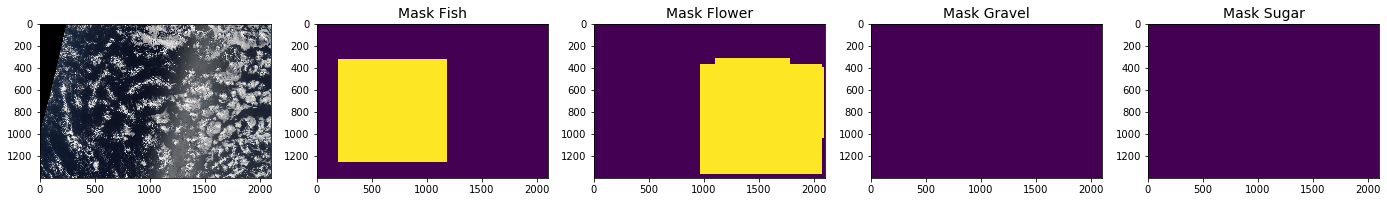

In [37]:
visualize(PIL.Image.open(train_dir/'0011165.jpg'), test_mask)

In [29]:
len(set([f.name for f in train_dir.ls()]).intersection(set(train_meta.filename) ))

5546

In [41]:
test_mask_camvid = make_mask_camvid(train_meta, image_name='0011165.jpg', shape= (1400, 2100))
test_mask_camvid.max()

2.0

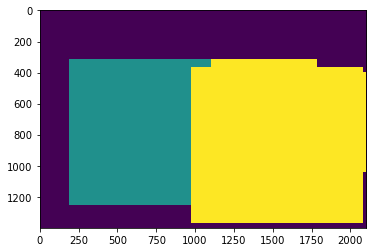

In [42]:
plt.imshow(test_mask_camvid * 255)

In [8]:
mask_dir = data_dir/"train_masks"


In [49]:
def create_mask_files(fname):
    mask = make_mask_camvid(train_meta, image_name=fname, shape= (1400, 2100))
    (PIL.Image.fromarray(mask)).save(mask_dir/fname.replace('jpg', 'png'), mode='L')
%time _=[create_mask_files(f) for f in train_meta.filename.unique()]

CPU times: user 2min 30s, sys: 211 ms, total: 2min 30s
Wall time: 2min 30s


In [16]:

def MulticlassDiceFlat(*args, axis:int=-1, **kwargs):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    return FlattenedLoss(L.MulticlassDiceLoss, *args, axis=axis, **kwargs)

dice_ce_loss =  L.JointLoss(CrossEntropyFlat(), MulticlassDiceFlat())

In [7]:
def foreground_dice(input, target):
    input = input.cuda()
    target = target.cuda()
    y_onehot = torch.empty_like(input, device=target.device, requires_grad=False)
    y_onehot.scatter_(1, target, 1).float()
    
    input = input[:, 1:, :, :]
    y_onehot = y_onehot[:, 1:, :, :]
    intersect = (input * y_onehot).sum(dim=1).float()
    union = (input+y_onehot).sum(dim=1).float()
#     print(intersect, union, intersect.shape, union.shape)
    return ((2. * intersect) / union).mean() if union.sum() > 0 else union.new([1.]).squeeze()
    
    

In [10]:
codes=["background"] + list(class_mapping.keys())
def get_mask_fn(fname):
    filepath = Path(fname).name.replace('jpg', 'png')
    return mask_dir/filepath
bs = 16
size=256
src = (SegmentationItemList.from_folder(train_dir)
       .filter_by_func(lambda f: Path(f).name.endswith('.jpg'))
       .split_by_rand_pct()
       .label_from_func(get_mask_fn, classes=codes)
      )


data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

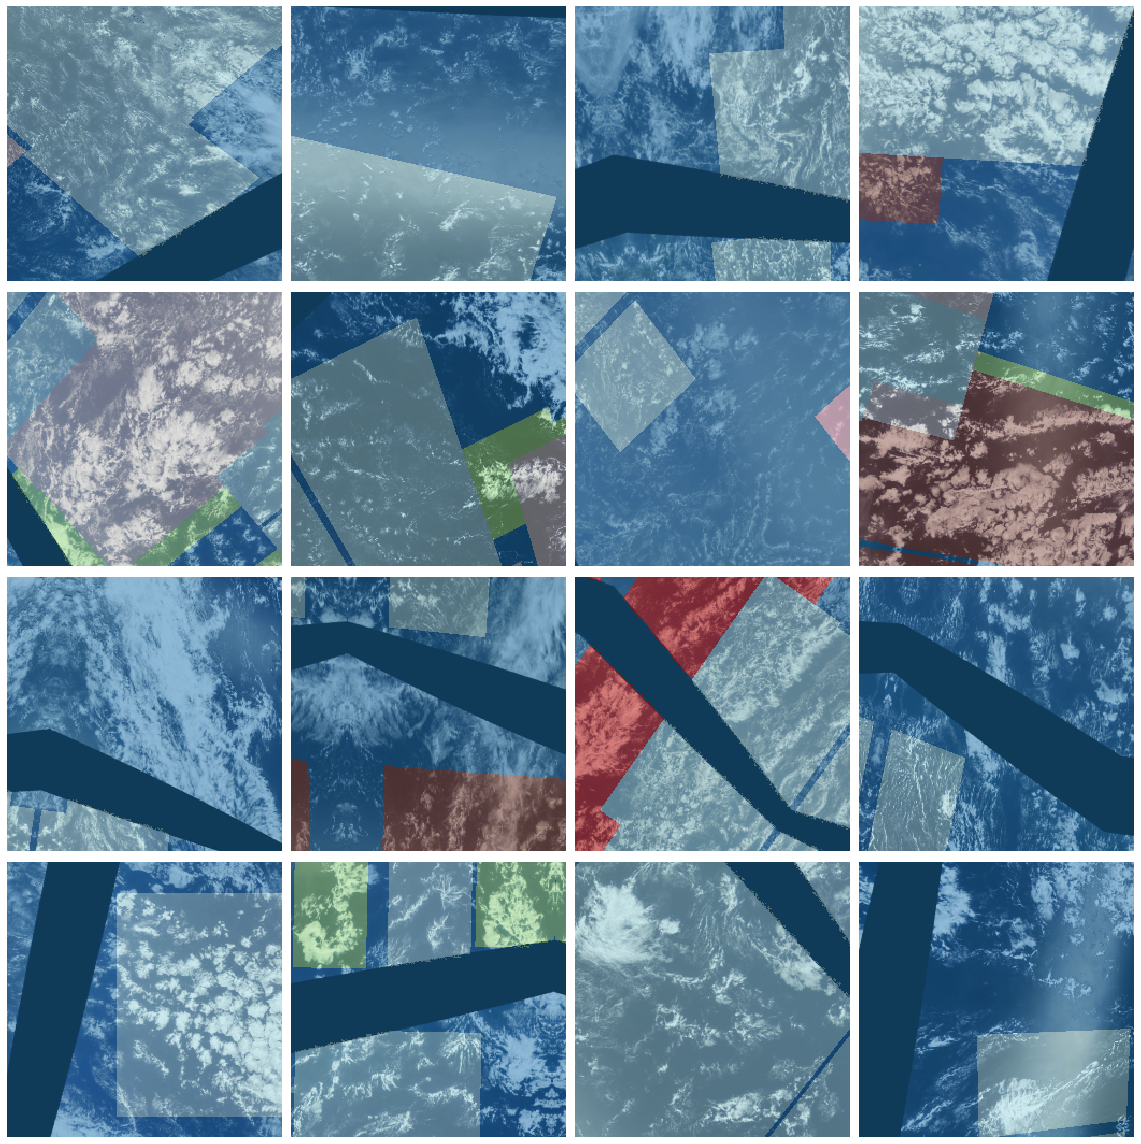

In [11]:
data.show_batch()

In [13]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
# project_id = 'segmentation_1'
# tboard_path = Path(data_dir/f'tensorboard/{project_id}')
# learn.callback_fns.append(partial(LearnerTensorboardWriter, 
#                                     base_dir=tboard_path, 
#                                     name='run1'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


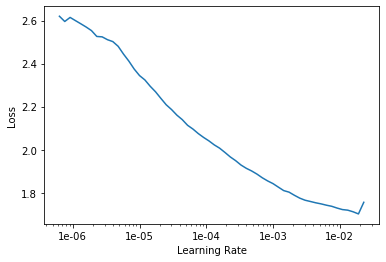

In [12]:
wd =1e-2
# metrics = [partial(foreground_acc,void_code=0), dice,foreground_dice
#            ]
metrics = [partial(foreground_acc,void_code=0), dice]
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.to_fp16()

learn.lr_find()
learn.recorder.plot()

In [76]:
metrics = [partial(foreground_acc,void_code=0), dice]
learn.metrics = metrics

In [13]:
lr =5e-4
learn.fit_one_cycle(1, slice(lr), pct_start=0.8,
   callbacks=[SaveModelCallback(learn, every='improvement', 
                                monitor='foreground_acc', name='init-attempt-2-dicenotworking')])

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,1.217145,1.117553,0.367290,2.069109,02:00


Better model found at epoch 0 with foreground_acc value: 0.3672897517681122.


In [14]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8,
   callbacks=[SaveModelCallback(learn, every='improvement', 
                                monitor='foreground_acc', name='init-attempt-2-dicenotworking')])

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,1.123599,1.062392,0.413571,2.253805,01:59
1,1.122566,1.047030,0.388675,2.207477,02:00
2,1.113582,1.062474,0.502256,2.317608,01:58
3,1.102664,1.069792,0.439014,2.016870,01:57
4,1.101934,1.085189,0.406769,1.940100,01:57
5,1.129038,1.025380,0.434844,2.223794,01:57
6,1.097385,1.058603,0.437951,2.185970,01:57
7,1.076764,0.993458,0.445363,2.006924,01:57
8,1.047708,0.984522,0.463758,2.035773,01:57
9,1.005274,0.948742,0.501368,2.212216,01:57


Better model found at epoch 0 with foreground_acc value: 0.41357120871543884.
Better model found at epoch 2 with foreground_acc value: 0.5022557973861694.


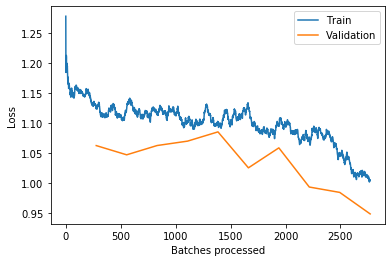

In [15]:
learn.recorder.plot_losses()

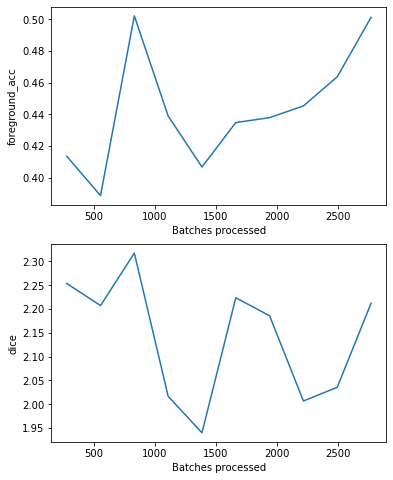

In [16]:
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


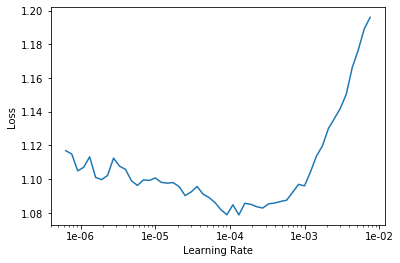

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [18]:
lr =5e-5
learn.fit_one_cycle(10, slice(lr), pct_start=0.8,
   callbacks=[SaveModelCallback(learn, every='improvement', 
                                monitor='foreground_acc', name='init-attempt-2-dicenotworking-unfrozen')])

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,1.074245,1.010877,0.441751,2.097681,01:58
1,1.089360,0.998673,0.455824,2.164629,01:59
2,1.044480,0.987861,0.457269,2.149403,01:59
3,1.045483,0.977265,0.447927,2.119036,01:59
4,1.044647,0.980321,0.510150,2.186960,01:59
5,1.049700,0.976684,0.521307,2.259361,02:02
6,1.053852,0.960669,0.466441,2.172576,01:58
7,1.040096,0.959274,0.498788,2.193258,02:00
8,1.023152,0.950692,0.510426,2.192167,01:57
9,0.992865,0.942840,0.527610,2.204145,01:57


Better model found at epoch 0 with foreground_acc value: 0.4417506754398346.
Better model found at epoch 1 with foreground_acc value: 0.455823689699173.
Better model found at epoch 2 with foreground_acc value: 0.4572691023349762.
Better model found at epoch 4 with foreground_acc value: 0.5101500749588013.
Better model found at epoch 5 with foreground_acc value: 0.521307110786438.
Better model found at epoch 9 with foreground_acc value: 0.5276104807853699.


In [52]:
batchtest = next(iter(learn.dl()))
# learn.dl()
# batchtest

In [53]:
batchtest[0].shape, batchtest[1].shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 1, 256, 256]))

In [57]:
test_pred = learn.pred_batch(batchtest)

In [60]:
test_pred.shape

torch.Size([16, 5, 256, 256])

In [73]:
foreground_dice(test_pred, batchtest[1])

tensor([[[[1.2458e-01, 1.5432e-01, 1.0198e-01,  ..., 6.1022e-02,
           5.2150e-02, 6.4562e-02],
          [9.5535e-02, 1.0486e-01, 8.0060e-02,  ..., 4.3864e-02,
           4.7422e-02, 6.0314e-02],
          [9.1601e-02, 9.7733e-02, 1.0763e-01,  ..., 4.5489e-02,
           4.6549e-02, 6.6539e-02],
          ...,
          [1.6144e-01, 1.5759e-01, 1.4672e-01,  ..., 2.5295e-02,
           2.6203e-02, 2.0313e-02],
          [1.4987e-01, 1.3950e-01, 1.6548e-01,  ..., 3.8452e-02,
           4.4204e-02, 5.2717e-02],
          [1.4221e-01, 1.2545e-01, 1.6194e-01,  ..., 3.0946e-02,
           5.7542e-02, 6.2432e-02]],

         [[1.4415e-01, 1.7722e-01, 1.2101e-01,  ..., 3.3010e-01,
           2.4323e-01, 3.0950e-01],
          [1.2717e-01, 1.4538e-01, 1.0026e-01,  ..., 3.0334e-01,
           2.4634e-01, 2.5307e-01],
          [1.6683e-01, 1.5634e-01, 9.4613e-02,  ..., 4.0442e-01,
           2.5611e-01, 3.8847e-01],
          ...,
          [2.2436e-01, 2.1083e-01, 1.3078e-01,  ..., 5.4467

tensor(0.1035, device='cuda:0')

In [64]:
y_onehot = torch.empty_like(test_pred, device=test_pred.device, requires_grad=False)
y_onehot.device

device(type='cpu')

In [66]:
y_onehot.cuda().scatter_(1, batchtest[1], 1).float()

tensor([[[[0.0000e+00, 0.0000e+00, 1.8493e-40,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000

In [21]:
a = [[1],[0], [1],[1]]
c =[[0,1], [1,0], [1,0], [0,1]]

In [22]:
at = torch.LongTensor(a)
ct = torch.FloatTensor(c)

In [38]:
onehot = torch.empty((4,2))
onehot.scatter_(1, at, 1).float()
onehot

tensor([[0., 1.],
        [1., 0.],
        [1., 1.],
        [0., 1.]])

In [50]:
intersect = (ct * onehot).sum().float()
union = (ct+onehot).sum().float()

In [47]:
ct.shape, onehot.shape

(torch.Size([4, 2]), torch.Size([4, 2]))

In [52]:
(ct * onehot)

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])

In [54]:
(ct * onehot).sum(dim=0)

tensor([2., 2.])

In [55]:
(ct+onehot).sum(dim=0).float()

tensor([4., 5.])

In [56]:
(2 * (ct * onehot).sum(dim=0))/(ct+onehot).sum(dim=0).float()

tensor([1.0000, 0.8000])

In [57]:
((2 * (ct * onehot).sum(dim=0))/(ct+onehot).sum(dim=0).float()).mean()

tensor(0.9000)

In [24]:
ct[0,1,:]

IndexError: too many indices for tensor of dimension 2